<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_09_auto_ml_6_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Finance 20200726

In [1]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

In [2]:
if COLAB:
  !pip install -U xgboost

  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

     |████████████████████████████████| 127.6MB 31kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Cloning into 'dl-projects'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 2099 (delta 72), reused 25 (delta 10), pack-reused 1977
Receiving objects: 100% (2099/2099), 79.20 MiB | 33.74 MiB/s, done.
Resolving deltas: 100% (1297/1297), done.


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys
import gc
import xgboost as xgb

from scipy import stats
from collections import Counter
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, make_scorer, recall_score, roc_curve, mean_squared_error, accuracy_score, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, RepeatedStratifiedKFold
from collections import Counter
from dateutil.relativedelta import relativedelta

from utils import feature_selection, plot_feature_importances
from plot import plot_correlation_matrix, plot_labeled_scatter

from IPython.display import display

from preprocess import *

np.set_printoptions(threshold=sys.maxsize)
plt.style.use('fivethirtyeight')
sns.set(style="ticks")

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [6]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("../datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 5149M
-rw------- 1 root root   17M Jul  6 14:06 feature_matrix_2020_apr.ft
-rw------- 1 root root   17M Jul  6 14:06 feature_matrix_2020_apr_orig.pkl
-rw------- 1 root root   17M Mar  1 05:47 feature_matrix_2020_feb.ft
-rw------- 1 root root   17M Mar  1 05:39 feature_matrix_2020_jan.ft
-rw------- 1 root root   17M Jul  7 13:52 feature_matrix_2020_jul.ft
-rw------- 1 root root   17M Jul  7 13:52 feature_matrix_2020_jul_orig.pkl
-rw------- 1 root root   17M Jul  5 07:30 feature_matrix_2020_jun.ft
-rw------- 1 root root   17M Jul  5 07:30 feature_matrix_2020_jun_orig.pkl
-rw------- 1 root root   17M Jul  6 13:56 feature_matrix_2020_mar.ft
-rw------- 1 root root   17M Jul  6 13:56 feature_matrix_2020_mar_orig.pkl
-rw------- 1 root root   17M Jul  7 13:40 feature_matrix_2020_may.ft
-rw------- 1 root root   17M Jul  7 13:40 feature_matrix_2020_may_orig.pkl
-rw------- 1 root root 2454M Jan 12  2020 feature_matrix_d2_v2.ft
-rw------- 1 root root 1585M Jan 12  2020 feature_matrix_d2_v3.f

In [8]:
# Read the data
data = pd.read_feather(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

In [9]:
# Display null rows
# data[data.isna().any(axis=1)]
#for col in data.columns:
#  print(col)
#
#data.head(1).T

## Add new data

In [10]:
data.shape

(959893, 217)

In [11]:
jan_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_jan.ft")
feb_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_feb.ft")
mar_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_mar.ft")
apr_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_apr.ft")
may_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_may.ft")
jun_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_jun.ft")
jul_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_jul.ft")

In [12]:
new_data = data.append(jan_2020[data.columns],ignore_index=True)
new_data = new_data.append(feb_2020[data.columns],ignore_index=True)
new_data = new_data.append(mar_2020[data.columns],ignore_index=True)
new_data = new_data.append(apr_2020[data.columns],ignore_index=True)
new_data = new_data.append(may_2020[data.columns],ignore_index=True)
new_data = new_data.append(jun_2020[data.columns],ignore_index=True)
new_data = new_data.append(jul_2020[data.columns],ignore_index=True)
new_data.shape 

(1029893, 217)

In [13]:
data = new_data
data.shape

(1029893, 217)

In [14]:
data.isna().sum().sort_values(ascending=False)

CUM_SUM(SKEW(Results.TotalStrike))           7685
CUM_MEAN(TREND(Results.DrawNo, DrawDate))    7685
TREND(Results.CUM_SUM(DrawNo), DrawDate)     7685
TREND(Results.CUM_SUM(LuckyNo), DrawDate)    7685
CUM_SUM(SKEW(Results.LuckyNo))               7685
                                             ... 
CUM_SUM(MIN(Results.DrawNo))                    0
NUM_UNIQUE(Results.DAY(DrawDate))               0
NUM_UNIQUE(Results.MONTH(DrawDate))             0
SUM(Results.PERCENTILE(LuckyNo))                0
NumberId                                        0
Length: 217, dtype: int64

In [15]:
#display(data.head(10).T)

## Exploratory Data Analysis

### View data

In [16]:
# Feature matrix
#feature_matrix = data.drop(columns=['NumberId', 'month', 'year'])
feature_matrix = data

In [17]:
# Sort data
feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029893 entries, 7020 to 1026411
Columns: 217 entries, NumberId to year
dtypes: datetime64[ns](1), float64(155), int64(59), uint8(2)
memory usage: 1.7 GB


In [18]:
print('Distribution')
print(feature_matrix['Label'].value_counts())
print()
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Distribution
0    996848
1     33045
Name: Label, dtype: int64

Positive: 996848 which is  96.79 % of the dataset
Negative: 33045 which is  3.21 % of the dataset


In [19]:
feature_matrix.isna().sum().sort_values(ascending=False)

CUM_SUM(SKEW(Results.TotalStrike))           7685
CUM_MEAN(TREND(Results.DrawNo, DrawDate))    7685
TREND(Results.CUM_SUM(DrawNo), DrawDate)     7685
TREND(Results.CUM_SUM(LuckyNo), DrawDate)    7685
CUM_SUM(SKEW(Results.LuckyNo))               7685
                                             ... 
CUM_SUM(MIN(Results.DrawNo))                    0
NUM_UNIQUE(Results.DAY(DrawDate))               0
NUM_UNIQUE(Results.MONTH(DrawDate))             0
SUM(Results.PERCENTILE(LuckyNo))                0
NumberId                                        0
Length: 217, dtype: int64

### Feature Selection

In [20]:
# Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [21]:
feature_matrix.shape

(1029893, 217)

In [22]:
# With feature selection
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label']))

# Without feature selection
# feature_matrix_selection = feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label'])

Original shape:  (1029893, 214)
0 missing columns with threshold: 90.
41 zero variance columns.
111 collinear columns removed with threshold: 0.95.
Total columns removed:  152
Shape after feature selection: (1029893, 62).


In [23]:
feature_matrix_selection.shape, feature_matrix_selection.columns

((1029893, 62),
 Index(['NumberId', 'STD(Results.DrawNo)', 'MAX(Results.DrawNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
        'TREND(Results.DrawNo, DrawDate)', 'MONTH(first_Results_time)',
        'DAY(first_Results_time)', 'TIME_SINCE(first_Results_time)',
        'TIME_SINCE_PREVIOUS(first_Results_time)',
        'STD(Results.PERCENTILE(DrawNo))',
        'STD(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'STD(Results.CUM_SUM(DrawNo))', 'STD(Results.CUM_MEAN(LuckyNo))',
        'MAX(Results.PERCENTILE(DrawNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MAX(Results.CUM_MEAN(LuckyNo))',
        'MIN(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'MIN(Results.CUM_SUM(DrawNo))', 'MIN(Results.CUM_MEAN(LuckyNo))',
        'MODE(Results.MONTH(DrawDate))', 'MODE(Results.DAY(DrawDate))',
        'MEAN(Results.TI

In [24]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['TotalStrike'] = feature_matrix['TotalStrike']
feature_matrix_selection['Label'] = feature_matrix['Label']

In [25]:
feature_matrix_selection.shape

(1029893, 65)

## Modeling

In [26]:
def to_labels(pos_probs, threshold):
    """Apply threshold to positive probabilities to create labels.
    """
    return (pos_probs >= threshold).astype('int')
 

def score_optimization(dt, feature_matrix, clf, X_train, y_train, X_test, y_test):

    print("\nUse the passed in classifier...\n")
    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    # keep probabilities for the positive outcome only
    probas = clf.predict_proba(X_test)[:, 1]
    
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)

    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(probas, t)) for t in thresholds]

    # get best threshold
    ix = np.argmax(scores)
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

    # print recall
    print("\nRecall:",recall_score(y_test,y_pred))

    # Get imbalanced classification report
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()

    # Additionl info
    print('\n\nAdditional Info')
    print('='*40)
    positive = np.where((y_pred==1))
    print(f'Total predicted to be positive: {len(positive[0])} \n')

    pred = np.where((y_pred==1))
    all_preds = pred[0]

    # Total predicted matches
    print('First 23 matches')
    print(23, all_preds[0:23])
    #print(f'\n{probas[all_preds[0:23]]}\n') 

    print("\nTop 23 Probable Matches")
    #print('probas', probas)
    topN = np.argpartition(probas, -23)[-23:]
    print(f'\n{topN}\n')          # Top N most high probability numbers
    #print(f'\n{probas[topN]}\n')  # Top N probability

    # Check for 2 to 3 digits range 
    print('\n2 To 3 Digits\n')
    idx_range = np.where((all_preds < 1000) & (all_preds >= 10))
    #print(idx_range)
    range_numbers = all_preds[idx_range]
    print(len(range_numbers), range_numbers)
    #print(f'\n{probas[range_numbers]}\n') 


    # 2 to 3 Digits > Average Probas
    print('\n2 To 3 Digits Average Proba\n')
    avg_proba = np.average(probas[range_numbers])
    print(f'Average proba {avg_proba}\n')
    #idx_avg_proba = np.where(probas > avg_proba) 
    #print(len(idx_avg_proba[0]), idx_avg_proba[0])

    # 2 to 3 Digits > All Average Probas
    print('\n\nAll Average Proba\n')
    all_avg_proba = np.average(probas[all_preds])
    print(f'All average probas {all_avg_proba}\n')
    #idx_all_avg_proba = np.where(probas > all_avg_proba) 
    #print(len(idx_all_avg_proba[0]), idx_all_avg_proba[0])


    # All predicted matches
    # print('\n\nAll Predictions\n')
    # print(len(all_preds), all_preds)
    # print()
    # print(len(probas[all_preds]), probas[all_preds])
    
    #print('Debug')
    #print(pred)
    
    if len(positive[0]) > 0:
    
      # Matching draws
      print('\nMatched draws')
      md = np.where((y_pred==1) & (y_test==1))
      print(f"Count: {len(md[0])}, Index: {md}")
      month_data = feature_matrix.loc[feature_matrix['time'] == dt]
      numbers = month_data.iloc[md[0]][['NumberId']]

      print('\n\nTop 23 Possibility')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(topN))].head(23))  
      
      print('\n\nFirst 23 Numbers')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(pred[0][0:23]))].head(23))    
             

      print('\n\n2 To 3 Digits Numbers')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(range_numbers))].head(23))    
     

      print('\n\nAll matched')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(numbers['NumberId']))].head(100))    
                                                  
    else:
      print('No luck this month')  

    if len(range_numbers) >= 50:
      return False

    return True

In [27]:
def gen_train_test_set(dt, feature_matrix, file_prefix='data'): 
    
    # Subset labels
    train_labels = feature_matrix.loc[feature_matrix['time'] < dt, 'Label']
    test_labels = feature_matrix.loc[feature_matrix['time'] == dt, 'Label']

    # Features - add back 'NumberId', 'month'
    X_train = feature_matrix[feature_matrix['time'] < dt].drop(columns = ['time', 'Label', 'TotalStrike', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['time'] == dt].drop(columns = ['time', 'Label', 'TotalStrike', 'year', 'index'], errors='ignore')
    feature_names = list(X_train.columns)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))

    # Join the train data
    train = X_train.join(train_labels)
    print('Train data shape: ', train.shape)
    print('\nCounts of strikes vs non-strikes in previous data:')
    print(train.Label.value_counts())
    print('-'*40)

    # sklearn pipeline
    pipeline = make_pipeline(
        SimpleImputer(strategy = 'constant', fill_value=0),
        StandardScaler())
    
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    # Saving the data
    X_train = pd.DataFrame(X_train,columns=feature_names)
    y_train = pd.DataFrame(y_train,columns=['Label'])

    # For X_test, now only use the selected features
    X_test = pd.DataFrame(X_test,columns=feature_names)
    y_test = pd.DataFrame(y_test,columns=['Label'])

    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

    X_train.to_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
    y_train.to_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
   
    X_test.to_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
    y_test.to_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")

    gc.collect()


In [28]:
def model(dt, feature_matrix, file_prefix='data', estimators=300, depth=3):
    """Predict for a particular month.
    """

    # Load train test
    X_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
    y_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
    X_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
    y_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")

    print(f'\n-----------{dt}-----------------\n')

    # Reshape
    y_train = np.array(y_train).reshape((-1, ))
    y_test = np.array(y_test).reshape((-1, ))
    
    print('Data shape')
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # Calculate hit ratio for xgboost classifier
    print("\nCalculating scale pos weight")
    counter = Counter(y_train)
    print(Counter(y_train))
    scale_pos_weight = float(counter[0] / counter[1])
    print(f"\nScale pos weight - {scale_pos_weight}\n")
    
     # Modeling
    eval_set=[(X_train, y_train), (X_test, y_test)]
    clf = xgb.XGBClassifier(
                    n_jobs=4, 
                    random_state=42,
                    objective='binary:logistic',
                    #subsample=0.55, 
                    n_estimators=estimators,
                    #min_child_weight=1,
                    max_depth=depth, 
                    learning_rate=0.007,
                    #gamma=0.1, 
                    #colsample_bytree=0.95,
                    #tree_method='hist',
                    booster='dart',
                    scale_pos_weight=scale_pos_weight,
                    eval_metric='auc',
                    #eval_set=eval_set,
                    #early_stopping_rounds=10
                    )

    clf_params = clf.get_params()
    print(clf_params)

    # Test and validate
    ret_val = score_optimization(dt,
                       feature_matrix,
                       clf, 
                       X_train, 
                       y_train, 
                       X_test, 
                       y_test)

    gc.collect()

    return ret_val

In [29]:
target_mth = pd.datetime(2020,2,1)
%time gen_train_test_set(target_mth, feature_matrix_selection, file_prefix='test')

Training on 969893 observations.
Testing on 10000 observations.

Train data shape:  (969893, 63)

Counts of strikes vs non-strikes in previous data:
0    937508
1     32385
Name: Label, dtype: int64
----------------------------------------
X_train: (969893, 62), y_train: (969893, 1)
X_test: (10000, 62), y_test: (10000, 1)
CPU times: user 3.58 s, sys: 489 ms, total: 4.07 s
Wall time: 9.92 s



-----------2020-02-01 00:00:00-----------------

Data shape
(969893, 62) (969893,) (10000, 62) (10000,)

Calculating scale pos weight
Counter({0: 937508, 1: 32385})

Scale pos weight - 28.94883433688436

{'objective': 'binary:logistic', 'base_score': None, 'booster': 'dart', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.007, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 500, 'n_jobs': 4, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': 28.94883433688436, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eval_metric': 'auc'}

Use the passed in classifier...


TEST GROUP
Threshold=0.493, F-Score=0.06459

Recall: 0.12618296529968454
              precision    recall  f1-sc

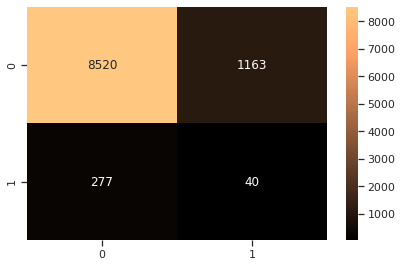



Additional Info
Total predicted to be positive: 1203 

First 23 matches
23 [  5  29  33  35  42  52  70  71  72  78  81 102 113 117 151 179 188 193
 196 197 210 219 236]

Top 23 Probable Matches

[5070 2922 2643  589 4512 4302 2863 3348 3061 4770  485 3697 2992 2244
 3087 4185 4164 2596 1668 2420 4352 1646 2636]


2 To 3 Digits

168 [ 29  33  35  42  52  70  71  72  78  81 102 113 117 151 179 188 193 196
 197 210 219 236 240 249 258 271 274 276 279 282 283 288 298 321 322 328
 340 341 344 347 349 352 354 382 384 391 393 402 411 421 425 430 446 450
 451 454 459 468 479 485 494 495 498 499 500 507 508 509 519 520 535 537
 538 540 544 546 553 557 560 567 568 570 575 580 581 585 589 591 603 604
 607 609 625 626 630 649 650 651 654 659 661 667 668 682 691 692 695 699
 706 715 720 725 731 733 739 743 745 765 771 773 776 780 793 796 798 799
 803 807 811 816 818 823 824 825 833 835 855 862 864 868 871 876 886 887
 888 892 895 896 903 910 911 914 915 922 923 925 928 929 942 952 953 966
 974 9

In [30]:
#for (estimators, depth) in ((300,3), (500,6), (550,6), (600,6)):
for (estimators, depth) in ((500,6),):
  %time model(target_mth, feature_matrix_selection, file_prefix='test', estimators=estimators, depth=depth)

In [31]:
# Classification metrics optimization?

# Grid search for Xgboost?

# Mean encoding?